In [73]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns

DECISION TREE MODEL:

Models: DecisionTreeRegressor, AdaBoostRegressor, RandomForestRegressor
```
DEPTH = 5
models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH)
}
```

Output: Offence rate at time t (t in 2015, 2016 due to limited communities data)
Change to the difference, since it's what we should focus on.
Assumptions: The communities.csv contains the data for 2014, 2015 (assume constant across the span of 2-3 years)
Features input: 
1. All features from communities (with 2 extra features for distance) at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
2. Only the top 20 features from communities with the highest NMI with offence rate at t-1, housing price at t-1, egm at t-1, offence rate at t-1 

Evaluation: 50 folds validation, and take the median of RMSE/ MSE

Results: Noted below

Conclusion:
For both features set, only adaboost performs better than re-use the offence rate at (t-1).
Features set 2 results in a lower RMSE for adaboost and random forest.

Result:
```
For features 1:
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 697426.027159028
RMSE of regressor : 835.120329157219
MSE of ada : 383065.340033446
RMSE of ada : 618.9163007242792
MSE of rf : 570348.7403033725
RMSE of rf : 755.1780375340123
```
For features 2:
```
MSE of null : 6481737.763176319
RMSE of null : 2545.9124068089195
MSE of null2 : 451612.1850000003
RMSE of null2 : 672.0083909964821
MSE of regressor : 687015.5763979282
RMSE of regressor : 828.81992487444
MSE of ada : 373469.0699750013
RMSE of ada : 611.1193833613015
MSE of rf : 515237.70031876455
RMSE of rf : 717.6376753858078
```

In [74]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Year ending", "Police Region", "Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [75]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [76]:

# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

modelData.columns = modelData.columns.astype('str')

modelData

,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,46,47,48,49,50,51,52,53,54,55
0,2016,7903.7,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016,9375.1,19.419507,128.349256,0.000000,0.000000,0.000000,0.016543,0.213052,0.474939,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016,10864.1,14.544640,45.693749,0.000000,0.000000,0.000000,0.029054,0.067348,0.697212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016,7166.8,16.202194,65.887204,0.000000,0.000000,0.000000,0.010994,0.107162,0.366402,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,11420.0,23.587200,599.996103,0.023828,0.037001,0.029642,0.016390,0.026318,0.094048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2015,11385.6,384.960766,23359.313312,2.687931,3.482185,3.087847,0.000074,0.000461,0.001773,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,2015,6857.1,58.368445,2142.863230,0.331739,0.880712,0.598316,0.000394,0.002019,0.020584,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,2015,9876.3,179.410340,6720.196354,2.135649,2.837918,2.452597,0.000128,0.000423,0.002905,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,2015,5198.3,94.497165,1652.413568,0.512327,0.704602,0.606605,0.000191,0.000432,0.016410,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# # Add the pca of all attributes (since decision tree doesn't deal with combinations of factor)
# # Only add to training
# from sklearn.decomposition import PCA

# sklearn_pca = PCA(n_components=1)
# X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
# features_pca = sklearn_pca.fit_transform(X)

# modelData["pca"] = features_pca
# explained_var = sklearn_pca.explained_variance_ratio_
# print("Variance explained by each PCA feature: ", explained_var)
# print("Total explained: ", sum(explained_var))


In [78]:
from sklearn.model_selection import train_test_split

X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
y = (modelData["Rate per 100,000 population"] - modelData["Last Offence Rate"])

# 19 random state yields some odd precision, likely due to how the split is constructed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=100)

FEATURES 1

In [79]:
# Define models here
# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor

DEPTH = 4

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=300, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = DEPTH,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error")
}

In [80]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

RMSE null:  631.7774855522052
RMSE of  regressor : 711.0949757115591
RMSE of  ada : 642.5053158867295
RMSE of  rf : 559.8189656463702
RMSE of  gradBoost : 661.8580552771807


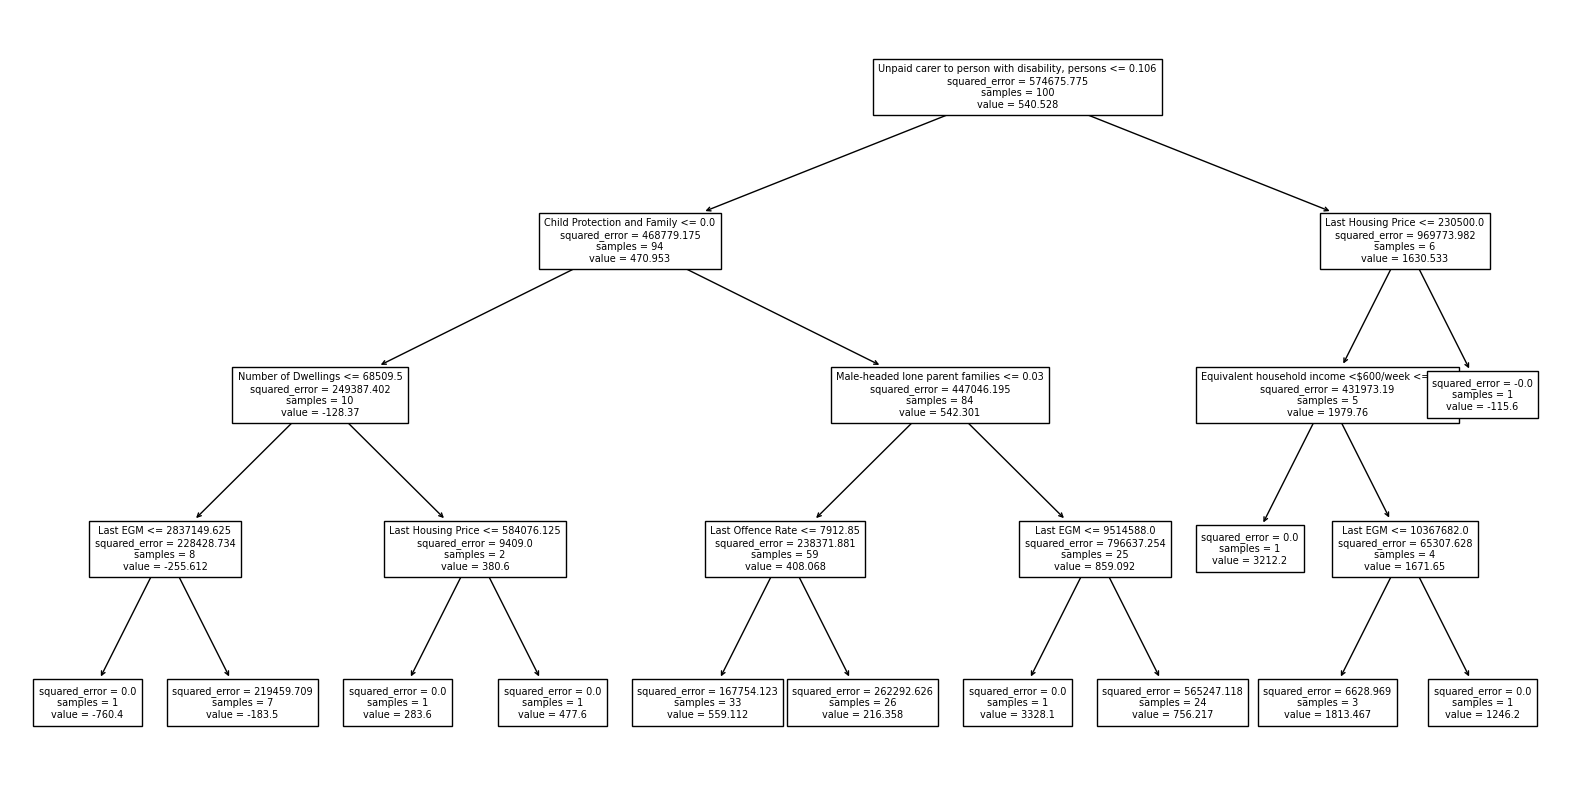

|--- Unpaid carer to person with disability, persons <= 0.11
|   |--- Child Protection and Family <= 0.00
|   |   |--- Number of Dwellings <= 68509.50
|   |   |   |--- Last EGM <= 2837149.62
|   |   |   |   |--- value: [-760.40]
|   |   |   |--- Last EGM >  2837149.62
|   |   |   |   |--- value: [-183.50]
|   |   |--- Number of Dwellings >  68509.50
|   |   |   |--- Last Housing Price <= 584076.12
|   |   |   |   |--- value: [283.60]
|   |   |   |--- Last Housing Price >  584076.12
|   |   |   |   |--- value: [477.60]
|   |--- Child Protection and Family >  0.00
|   |   |--- Male-headed lone parent families <= 0.03
|   |   |   |--- Last Offence Rate <= 7912.85
|   |   |   |   |--- value: [559.11]
|   |   |   |--- Last Offence Rate >  7912.85
|   |   |   |   |--- value: [216.36]
|   |   |--- Male-headed lone parent families >  0.03
|   |   |   |--- Last EGM <= 9514588.00
|   |   |   |   |--- value: [3328.10]
|   |   |   |--- Last EGM >  9514588.00
|   |   |   |   |--- value: [756.22]
|-

In [81]:
# Use hold out for now
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import mean_squared_error

predicts = {}

for name in models:
    model = models[name]
    models[name] = model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    predicts[name] = y_predict


y_null_predict = [y_train.mean()] * len(X_test)

mse_null = mean_squared_error(y_test, y_null_predict)

print("RMSE null: ", np.sqrt(mse_null))

for name in models:
    rmse = np.sqrt(mean_squared_error(predicts[name], y_test))
    print("RMSE of ", name, ":", rmse)



# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(20,10))
plot_tree(models["regressor"], 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=7)
plt.show()

# Use text
tree_rules = export_text(models["regressor"], feature_names=list(X_train))
print(tree_rules)

print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())



MSE of null : 437313.99340408796
RMSE of null : 661.2757876585754
MSE of regressor : 993231.0632940241
RMSE of regressor : 996.4505080854467
MSE of ada : 652579.6718915505
RMSE of ada : 806.7231501441695
MSE of rf : 596264.7287273403
RMSE of rf : 771.6966027833187
MSE of gradBoost : 772370.1432949682
RMSE of gradBoost : 877.6589678522428
Used attributes for regressor tree: 
Last EGM                                             46
Last Housing Price                                   46
Last Offence Rate                                    32
Requires assistance with core activities, persons    18
Child Protection and Family                          14
Aged Care (High Care)                                 8
Dental                                                6
Unpaid carer to person with disability, persons       4
Location_x                                            4
Male-headed lone parent families                      4
Holds degree or higher, persons                       4
Categor

<Figure size 640x480 with 0 Axes>

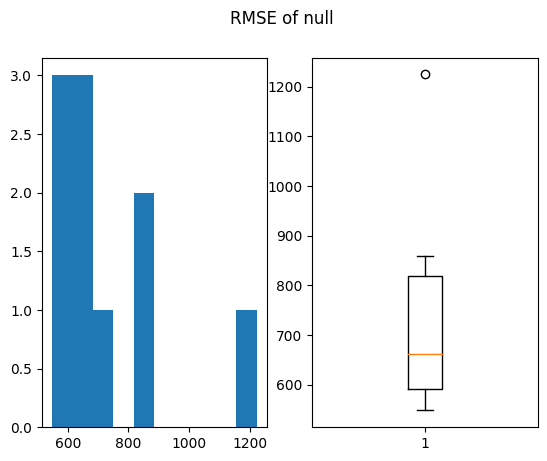

<Figure size 640x480 with 0 Axes>

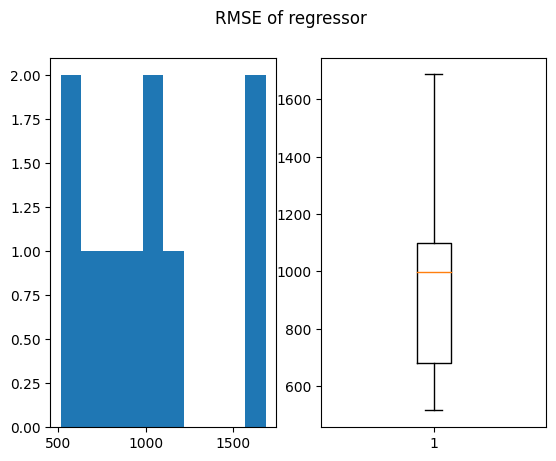

<Figure size 640x480 with 0 Axes>

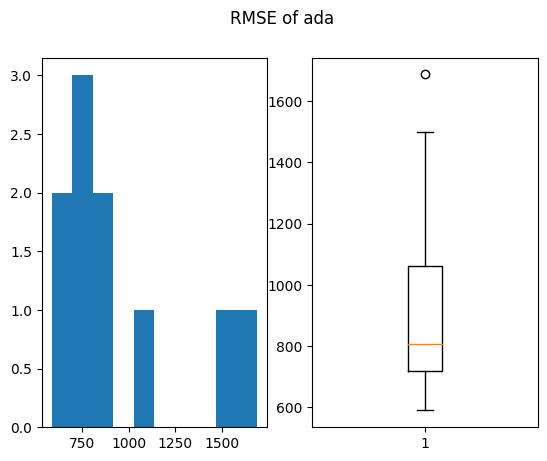

<Figure size 640x480 with 0 Axes>

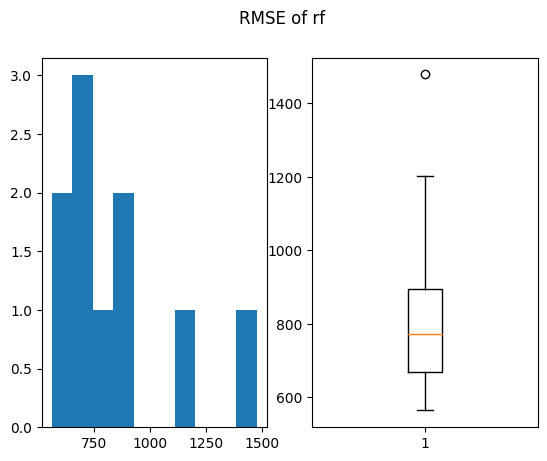

<Figure size 640x480 with 0 Axes>

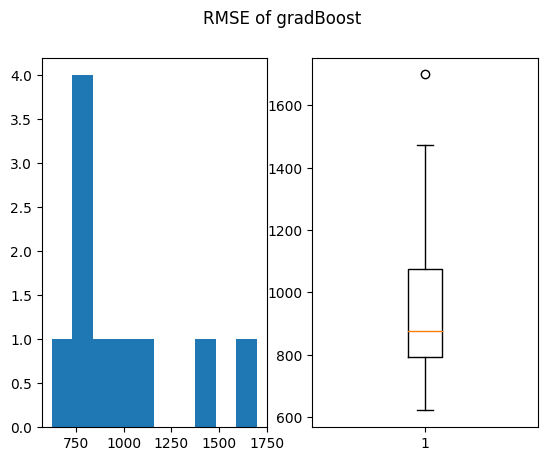

In [82]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold

# Change to 50 for actual evaluation
# n = 50
n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)

    mses["null"].append(mse_null)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())

for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()
    

FEATURE 2: Pick the top 20 highest NMI score features only

In [83]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Since most attribute uses the default discretiser, 
# this function will help with the NMI calculation
def getNMI(att1: np.array, att2: np.array, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    # Avoid the removal of bin by normalizing the data
    norm_att1 = (att1 - att1.min())/ (att1.max() - att1.min()) * 100
    norm_att2 = (att2 - att2.min())/ (att2.max() - att2.min()) * 100

    discrete_att1 = discretizer.fit_transform(norm_att1.reshape(-1, 1)).astype(int)
    discrete_att2 = discretizer.fit_transform(norm_att2.reshape(-1, 1)).astype(int)
    return normalized_mutual_info_score(discrete_att1.flatten(), discrete_att2.flatten())

def getTopNMICommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = getNMI(np.array(X_train[column]), np.array(y_train))
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose widt

MSE of null : 437313.99340408796
RMSE of null : 661.2757876585754
MSE of regressor : 624982.8434740526
RMSE of regressor : 789.2140220292629
MSE of ada : 642992.9631781247
RMSE of ada : 801.7803018764453
MSE of rf : 597997.0149070149
RMSE of rf : 773.2837240760739
MSE of gradBoost : 887783.2474180256
RMSE of gradBoost : 942.2225041938613
Used attributes for regressor tree: 
Last EGM                                                   52
Last Housing Price                                         42
Last Offence Rate                                          32
Holds degree or higher, persons                            16
Requires assistance with core activities, persons          14
Unemployed, persons                                        10
2012 ERP age 15-19, persons                                10
Aged 75+ and lives alone, persons                           8
Public Housing Dwellings                                    8
Industrial (km^2)                                           6
Cat

<Figure size 640x480 with 0 Axes>

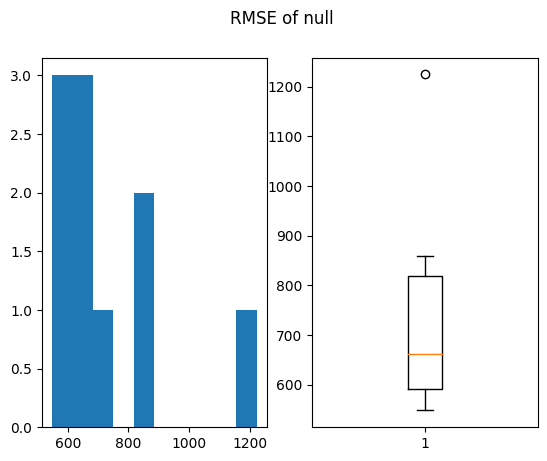

<Figure size 640x480 with 0 Axes>

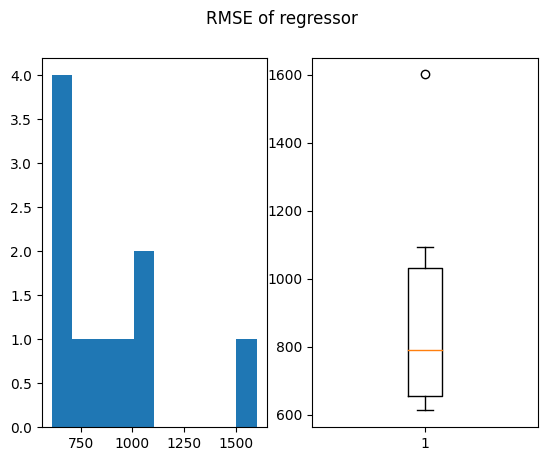

<Figure size 640x480 with 0 Axes>

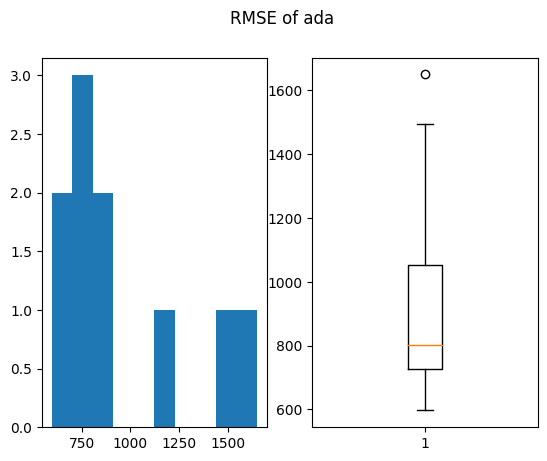

<Figure size 640x480 with 0 Axes>

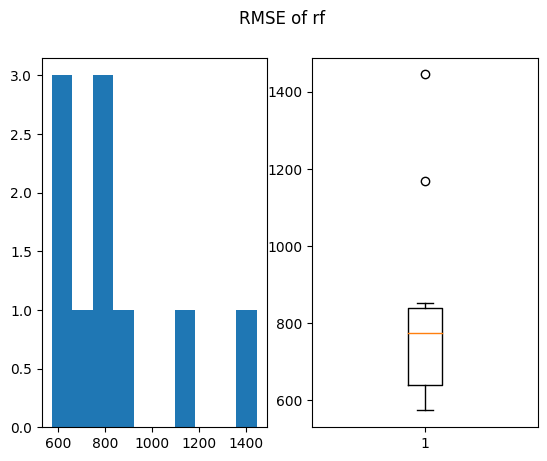

<Figure size 640x480 with 0 Axes>

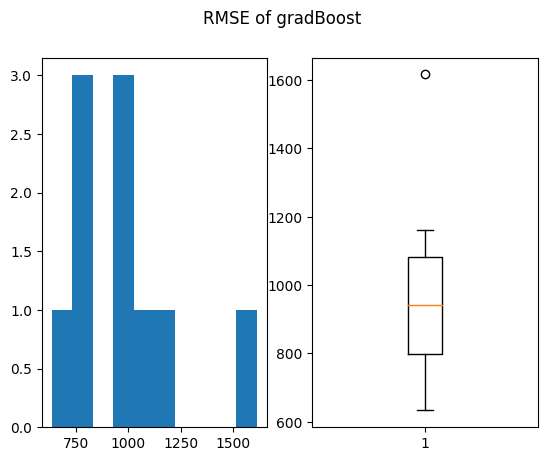

In [84]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold

n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    top20Communities = getTopNMICommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)

    mses["null"].append(mse_null)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()


    

FEATURE 3: 

Ignore communities, and try to fit with EGM, housing and past offence alone

In [85]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] >= 2015) & (offences["Year"] <= 2021)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    for shift in range(1, 2):
        modelData.loc[idx, "Last Offence Rate" + str(shift)] = offences[(offences["LGA"] == row["LGA"]) 
                                                & (offences["Year"] == row["Year"] - shift)]["Rate per 100,000 population"].iloc[0]
        modelData.loc[idx, "Last Housing Price" + str(shift)] = housingPrices.loc[row["LGA"]][str(row["Year"] - shift)]
        modelData.loc[idx, "Last EGM" + str(shift)] = egm.loc[row["LGA"]][str(row["Year"] - shift)]

# Drop all except the time series one
dropCol = []
for col in modelData.columns:
    flag = False
    for check in ["Last Offence Rate", "Last Housing Price", 
                  "Last EGM", "LGA", "Rate per 100,000 population"]:
        if check in col:
            flag = True
    if flag:
        continue
    dropCol.append(col)

modelData = modelData.drop(columns=dropCol)


# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

modelData.columns = modelData.columns.astype('str')

X = modelData.drop(columns=["Rate per 100,000 population"])
y = modelData["Rate per 100,000 population"] - modelData["Last Offence Rate1"]

modelData


,"Rate per 100,000 population",Last Offence Rate1,Last Housing Price1,Last EGM1,0,1,2,3,4,5,...,46,47,48,49,50,51,52,53,54,55
0,5771.4,7257.4,1.005577e+06,4.248559e+07,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8642.6,9899.5,6.758560e+05,1.019742e+08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8410.7,10020.0,1.062963e+06,5.694230e+07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6320.8,6119.1,8.938082e+05,3.461166e+07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7244.5,9026.3,7.308673e+05,8.593511e+07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,11385.6,11044.5,1.874375e+05,2.470024e+07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
388,6857.1,6183.6,3.395000e+05,1.030988e+07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389,9876.3,7947.7,1.587500e+05,1.035065e+07,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,5198.3,4886.7,6.456000e+05,2.855820e+06,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Define models here
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor


DEPTH = 7

models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=500, max_depth=DEPTH),
    "gradBoost": GradientBoostingRegressor(n_estimators = 500,
        max_depth = 4,
        min_samples_split = 3,
        learning_rate = 0.01,
        loss = "squared_error")
}

MSE of null : 945753.0496415866
RMSE of null : 972.221767072492
MSE of regressor : 1109382.7336616628
RMSE of regressor : 1053.1268667583622
MSE of ada : 936018.6203237588
RMSE of ada : 967.463433630102
MSE of rf : 914059.2540789472
RMSE of rf : 955.9315420901903
MSE of gradBoost : 938027.8552668688
RMSE of gradBoost : 968.5161006992315
Used attributes for regressor tree: 
Last Offence Rate1     346
Last EGM1              338
Last Housing Price1    278
24                      30
37                      30
6                       20
40                      14
9                       12
42                      12
48                      10
49                      10
18                       8
47                       8
3                        6
12                       6
10                       6
52                       6
30                       6
45                       6
36                       4
43                       4
53                       4
28                       4
20 

<Figure size 640x480 with 0 Axes>

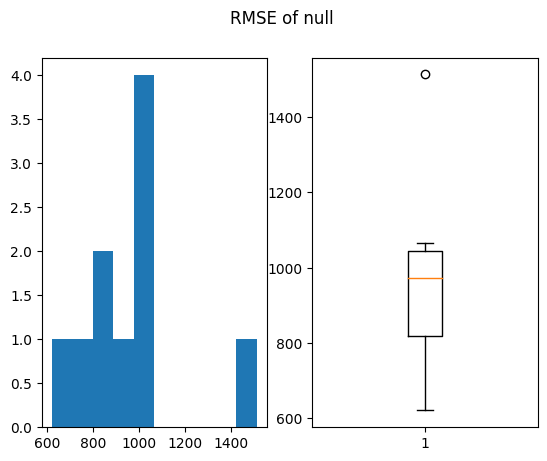

<Figure size 640x480 with 0 Axes>

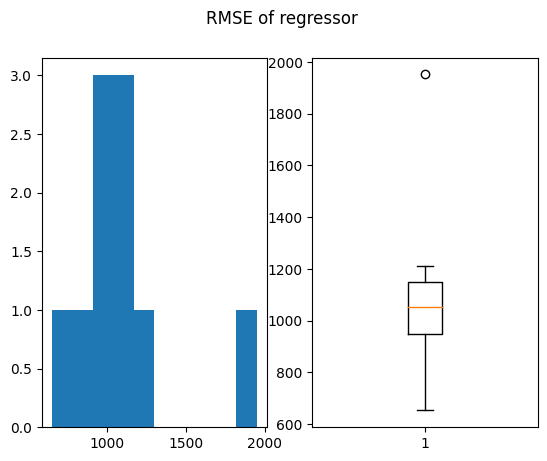

<Figure size 640x480 with 0 Axes>

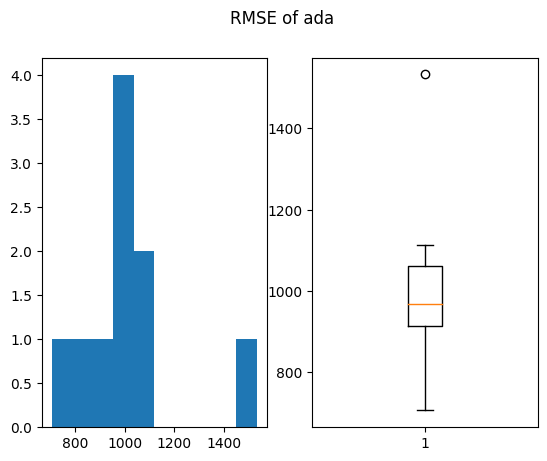

<Figure size 640x480 with 0 Axes>

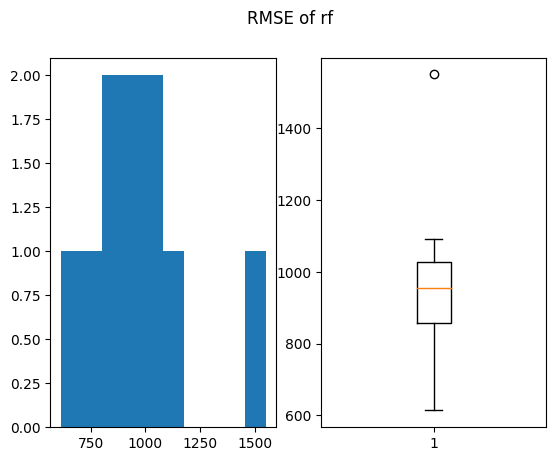

<Figure size 640x480 with 0 Axes>

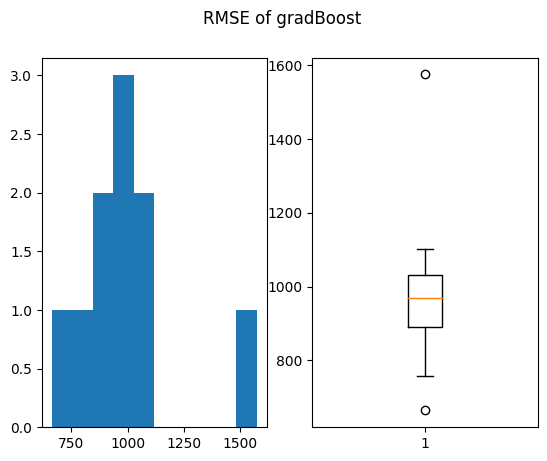

In [87]:
# Try restricting the input to only the top 10 highest NMI attribute from communities
from sklearn.model_selection import KFold

n = 10

nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
mses = {
    "null": []
}

relavantAttributes = []


for train_idx, test_idx in nf_CV.split(X):
    # train-test split
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    y_null_predict = [y_train.mean()] * len(X_test)

    predicts = {}
    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    mse_null = mean_squared_error(y_test, y_null_predict)

    mses["null"].append(mse_null)

    for name in models:
        mse = mean_squared_error(predicts[name], y_test)
        if name not in mses:
            mses[name] = []
        mses[name].append(mse)


    # if (np.sqrt(mse_ada) > 2000):
    #     print(X_test)
    #     print(y_test)

    # Get the summary of all attributes
    tree_rules = export_text(models["regressor"], feature_names=list(X_train))
    relavantAttributes.extend(getSplitAttributes(tree_rules))

# Print the RMSE for each model
for key in mses:
    print("MSE of", key, ":", np.median(mses[key]))
    print("RMSE of", key, ":", np.median(np.sqrt(mses[key])))



print("Used attributes for regressor tree: ")
print(pd.Series(relavantAttributes).value_counts())



for name in mses:
    plt.figure()
    fig, axs = plt.subplots(1, 2)
    fig.suptitle("RMSE of " + name)
    axs[0].hist(np.sqrt(mses[name]))
    axs[1].boxplot(np.sqrt(mses[name]))
    plt.show()


    